In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# # OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Imports

In [2]:

from pyspark.sql import SparkSession
from ydata_profiling import ProfileReport

from pyspark.sql import functions as f
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier, LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Create Spark and Import Data

In [3]:
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

## Read in full sparkify dataset
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
raw_df = spark.read.json(event_data)
raw_df.head()

Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042')

In [4]:
df = raw_df.persist()

In [5]:
df.show(3)

+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|     artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+-----------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|  Popol Vuh|Logged In|    Shlok|     M|          278| Johnson|524.32934| paid|Dallas-Fort Worth...|   PUT|NextSong|1533734541000|    22683|Ich mache einen S...|   200|1538352001000|"Mozilla/5.0 (Win...|1749042|
|Los Bunkers|Logged In|  Vianney|     F|            9|  Miller|238.39302| paid|San Francisco-Oak...|   PUT|NextSong|1537500318000|    20836|         MiÃ

# Data Exploration

## Initial overview using ydata-profiling library

Schema information - taken from https://www.kaggle.com/code/yukinagae/sparkify-project-churn-prediction

artist: Artist name (ex. Daft Punk) \
auth: User authentication status (ex. Logged) \
firstName: User first name (ex. Colin) \
gender: Gender (ex. F or M) \
itemInSession: Item count in a session (ex. 52) \
lastName: User last name (ex. Freeman) \
length: Length of song (ex. 223.60771) \
level: User plan (ex. paid) \
location: User's location (ex. Bakersfield \)
method: HTTP method (ex. PUT) \
page: Page name (ex. NextSong) \
registration: Registration timestamp (unix timestamp) (ex. 1538173362000) \
sessionId: Session ID (ex. 29) \
song: Song (ex. Harder Better Faster Stronger) \
status: HTTP status (ex. 200) \
ts: Event timestamp(unix timestamp) (ex. 1538352676000) \
userAgent: User's browswer agent (ex. Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0) \
userId: User ID (ex. 30) \

In [6]:
#the unique pages are:
df.select("page").distinct().show(23, truncate=False)

+-------------------------+
|page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+



## Key Observations from the ydata-profile report:

 - 26_259_199 rows
 - 18 columns
 - 14_710_249

- no duplicate rows

  ### Columns:

  - artist - missing values, to be expected when the interaction doesn't involve a song (e.g. logging in)
  - firstName - missing 778_479 values (note originally thought was 14_562_194 values but ydata report is confusing / bugged - see below)
  - gender - missing 778_479 (3%) of values
  - lastName - missing 778_479 values (note originally thought was 12_948_838 values but ydata report is confusing / bugged - see below)
  - level - 2 distinct values (paid / free), no missing - the majority (78%) are paying users
  - location - has missing values. Most popular locations seem to be in USA
  - page - 22 distinct values, none missing. Most visited page is "NextSong"
  - registration - no missing values, but some at 0 which will need to be checked / cleaned up
  - status - none missing, 3 distinct values: 200 (OK), 307 (Temporary Redirect), 404 (NOT FOUND)
  - ts - none missing, don't have the same "zeros" issue as registrations
  - userId - none missing, but one very common value (1261737). More checks might be required (e.g. for empty string)


 side note for the negotiating team - our most played artists are Kings of Leon and Coldplay so don't lose the rights to play their songs!

In [7]:
# Understand the many missing values in "firstName" / "lastName" column
# Code inspired by: https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/

df_missing_first_or_last_name = df.where(
    (f.col("firstName")=="") |
    (f.col("firstName").isNull()) |
    (f.col("lastName")=="") |
    (f.col("lastName").isNull())
    )
df_missing_first_or_last_name.show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+-------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent| userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+-------+
|  null|Logged Out|     null|  null|           87|    null|  null| paid|    null|   GET| Home|        null|     8615|null|   200|1538352008000|     null|1261737|
|  null|Logged Out|     null|  null|            0|    null|  null| free|    null|   PUT|Login|        null|     7433|null|   307|1538352041000|     null|1261737|
|  null|Logged Out|     null|  null|            4|    null|  null| free|    null|   GET| Home|        null|    25003|null|   200|1538352182000|     null|1261737|
|  null|Logged Out|     null

In [8]:
# what are the auth states for users missing names:
df_missing_first_or_last_name.select("auth").distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



In [9]:
# whilst users are always Logged Out or a guest (also not sure what the difference between those is), there are both levels (paid/free) as well as for the same userId: 1261737, which is the one we commented on having many more rows than all the other users. Keep digging:
df_missing_first_or_last_name.select("userId").distinct().show()

+-------+
| userId|
+-------+
|1261737|
+-------+



In [10]:
# So actually that is the only userId causing nulls in many columns 

df_missing_first_or_last_name.select("page").distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [11]:
# This user never goes to the "Upgrade" / "Submit Upgrade" page, so is odd they can have the "paid" level in the data. It could be some trial scheme sparkify has or similar, but as we don't know and since the "user" (it could be many different users that just get given the same id when logged out / a guest) is missing a lot of information about them (both personally and what they are doing on the platform e.g. how many songs listening to etc - if any), we will remove this user from the data

In [12]:
# But there are also more first names missing than last names:
df_missing_first_got_last = df_missing_first_or_last_name = df.where(
    (f.col("firstName").isNull()) &
    (f.col("lastName").isNotNull())
    )
df_missing_first_got_last.show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [13]:
# Code inspired by: https://sparkbyexamples.com/pyspark/pyspark-find-count-of-null-none-nan-values/

df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(), c)).alias(c) for c in ["firstName", "lastName"]]
   ).show()

+---------+--------+
|firstName|lastName|
+---------+--------+
|   778479|  778479|
+---------+--------+



In [14]:
# So there is not a different number of nulls in each of the columns. This is different to the values from ydata-profiling tool, which clearly has some sort of bug to be resolved.
#(reviewed and found an issue already exists that covers it: https://github.com/ydataai/ydata-profiling/issues/1429)

In [15]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [16]:
# Investigate / clean up registration==0/null rows
# observation from the ydata report is that it is the same number of rows as the missing first/last names so likely the same "issue"
df.where((f.col("registration")<1) |f.col("registration").isNull()).show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+-------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent| userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+-------+
|  null|Logged Out|     null|  null|           87|    null|  null| paid|    null|   GET| Home|        null|     8615|null|   200|1538352008000|     null|1261737|
|  null|Logged Out|     null|  null|            0|    null|  null| free|    null|   PUT|Login|        null|     7433|null|   307|1538352041000|     null|1261737|
|  null|Logged Out|     null|  null|            4|    null|  null| free|    null|   GET| Home|        null|    25003|null|   200|1538352182000|     null|1261737|
|  null|Logged Out|     null

In [17]:
df.select(f.min(f.col("registration"))).show()

+-----------------+
|min(registration)|
+-----------------+
|    1508018725000|
+-----------------+



In [19]:
#re-check some results given don't fully trust the ydata report now:
describe_pdf = df.describe().toPandas()
describe_pdf

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,20850272,26259199,25480720,25480720,26259199,25480720,20850272,26259199,25480720,26259199,26259199,25480720,26259199,20850272,26259199,26259199,25480720,26259199
1,mean,Infinity,None,Infinity,None,106.56267561702853,None,248.7254329674883,None,None,None,None,1.5352206652605132E12,100577.99253503505,NaN,210.06768953615074,1.5409056361137727E12,None,1488379.8347142653
2,stddev,NaN,None,NaN,None,117.65812617523801,None,97.28710387078068,None,None,None,None,3.2402990978250704E9,71909.2107787595,NaN,31.550728788197627,1.5158105552718897E9,None,286970.08894623973
3,min,!!!,Cancelled,Aaden,F,0,Abbott,0.522,free,"Aberdeen, SD",GET,About,1508018725000,1,Till Kingdom Come,200,1538352001000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",1000025
4,max,ÃÂ¼NN,Logged Out,Zytavious,M,1428,Zuniga,3024.66567,paid,"Zanesville, OH",PUT,Upgrade,1543821822000,240381,ÃÂ¾etta Gerist ÃÂ¡ Bestu BÃÂ¦jum,404,1543622402000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,1999996


# Data Cleaning

In [20]:
# filter out user 1261737
df = df.where(f.col("userId")!=1261737)

In [21]:
df.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
| artist|auth|firstName|gender|itemInSession|lastName| length|level|location|method|page|registration|sessionId|   song|status| ts|userAgent|userId|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+
|4630448|   0|        0|     0|            0|       0|4630448|    0|       0|     0|   0|           0|        0|4630448|     0|  0|        0|     0|
+-------+----+---------+------+-------------+--------+-------+-----+--------+------+----+------------+---------+-------+------+---+---------+------+



# Target Extraction

As we have seen that most of the Sparkify users are on the "paid" level, I have decided to try to come up with a model that will predict users that are more likely to leave that level (either by downgrading to the free level or closing their account altogether) in the hope this will have biggest impact on maintaining future revenue.

need to filter to just paid and flag those that downgraded?

In [22]:
df_user_ids = df.select("userID").distinct()
print(f"There are {df_user_ids.count()} unique userIds")

There are 22277 unique userIds


Filter the dataframe down to just the interactions had whilst users are on the paid tier, using the "phase" approach

In [23]:
df = df.withColumn("level_change",
    f.when(f.col("page")=="Submit Upgrade", 1)
    .when(f.col("page")=="Submit Downgrade", -1)
    .when(f.col("page")=="Cancellation Confirmation", -1)
    .otherwise(0))

window = Window.partitionBy("userId").orderBy(f.asc("ts")).rangeBetween(Window.unboundedPreceding, Window.currentRow)
df = df.withColumn("level_phase", f.sum("level_change").over(window))


In [24]:
df.select("userId", "page", "ts", "level_phase").where(f.col("page").isin(["Submit Upgrade", "Submit Downgrade", "cancellation Confirmation"])).sort("userId", "ts").show()

+-------+----------------+-------------+-----------+
| userId|            page|           ts|level_phase|
+-------+----------------+-------------+-----------+
|1000025|  Submit Upgrade|1538510602000|          1|
|1000035|  Submit Upgrade|1539635043000|          1|
|1000083|  Submit Upgrade|1539051434000|          1|
|1000103|  Submit Upgrade|1538683342000|          1|
|1000164|  Submit Upgrade|1539715737000|          1|
|1000168|  Submit Upgrade|1538689483000|          1|
|1000182|  Submit Upgrade|1539990415000|          1|
|1000214|Submit Downgrade|1538852249000|         -1|
|1000214|  Submit Upgrade|1540056711000|          0|
|1000214|Submit Downgrade|1541082453000|         -1|
|1000214|  Submit Upgrade|1542876934000|          0|
|1000233|  Submit Upgrade|1542319826000|          1|
|1000280|  Submit Upgrade|1539913798000|          1|
|1000280|Submit Downgrade|1539974239000|          0|
|1000407|  Submit Upgrade|1538499634000|          1|
|1000407|Submit Downgrade|1542211514000|      

In [25]:
#check the raw input for user 1000214 as shouldn't have a downgrade first (-1's):
raw_df.select("userId", "page", "ts").where((f.col("page").isin(["Submit Upgrade", "Submit Downgrade", "cancellation Confirmation"]))&(f.col("userId")==1000214)).sort("userId", "ts").show()

+-------+----------------+-------------+
| userId|            page|           ts|
+-------+----------------+-------------+
|1000214|Submit Downgrade|1538852249000|
|1000214|  Submit Upgrade|1540056711000|
|1000214|Submit Downgrade|1541082453000|
|1000214|  Submit Upgrade|1542876934000|
+-------+----------------+-------------+



In [26]:
df.where((f.col("page")=="Submit Upgrade")&(f.col("level_phase")!=1)).select("userId").distinct().count()

926

In [27]:
# So there are 926 users that had a downgrade / cancellation before an upgrade. sample ID's:
df.where((f.col("page")=="Submit Upgrade")&(f.col("level_phase")!=1)).select("userId").distinct().show()

+-------+
| userId|
+-------+
|1001246|
|1100489|
|1115082|
|1222193|
|1339632|
|1421038|
|1474426|
|1501443|
|1529262|
|1567000|
|1676292|
|1750353|
|1775420|
|1803077|
|1863821|
|1022581|
|1201787|
|1242483|
|1250440|
|1322754|
+-------+
only showing top 20 rows



In [28]:
# Double check a second sample
raw_df.select("userId", "page", "ts").where((f.col("page").isin(["Submit Upgrade", "Submit Downgrade", "cancellation Confirmation"]))&(f.col("userId")==1250440)).sort("userId", "ts").show()

+-------+----------------+-------------+
| userId|            page|           ts|
+-------+----------------+-------------+
|1250440|Submit Downgrade|1539015030000|
|1250440|  Submit Upgrade|1539644517000|
|1250440|Submit Downgrade|1539954044000|
|1250440|  Submit Upgrade|1540877615000|
|1250440|Submit Downgrade|1541476079000|
|1250440|  Submit Upgrade|1543398472000|
+-------+----------------+-------------+



So we see users that downgrade first, implying we must be missing earlier data which covers what they were doing as a paid user.
We want to know all the actions of paying users, missing interactions could be important in predicting churn, so "paying periods" with missing data will be filtered out.

Clean up: For all users that upgraded, remove any data before their first upgrade:

In [29]:
df = (df
      .withColumn("upgrade_flag", f.when(f.col("page")=="Submit Upgrade", 1).otherwise(0))
      .withColumn("upgrade_phase", f.sum("upgrade_flag").over(window))
      .where(f.col("upgrade_phase")>0)
)


In [30]:
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+-----------+------+--------------+-------------+---------+--------------------+------+-------------+--------------------+-------+------------+-----------+------------+-------------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|   location|method|          page| registration|sessionId|                song|status|           ts|           userAgent| userId|level_change|level_phase|upgrade_flag|upgrade_phase|
+----------------+---------+---------+------+-------------+--------+---------+-----+-----------+------+--------------+-------------+---------+--------------------+------+-------------+--------------------+-------+------------+-----------+------------+-------------+
|            null|Logged In|    Frank|     M|            7|  Warren|     null| free|Findlay, OH|   PUT|Submit Upgrade|1535470939000|    15200|                null|   307|1539913798000|Mozilla/5.0 (Wind.

In [31]:
# re-calculate level change and level phase cols with "cleaned" data:
df = df.withColumn("level_change",
    f.when(f.col("page")=="Submit Upgrade", 1)
    .when(f.col("page")=="Submit Downgrade", -1)
    .when(f.col("page")=="Cancellation Confirmation", -1)
    .otherwise(0))

window = Window.partitionBy("userId").orderBy(f.asc("ts")).rangeBetween(Window.unboundedPreceding, Window.currentRow)
df = df.withColumn("level_phase", f.sum("level_change").over(window))


In [32]:
df.select("userId", "page", "ts", "level_phase").where(f.col("page").isin(["Submit Upgrade", "Submit Downgrade", "cancellation Confirmation"])).sort("userId", "ts").show()

+-------+----------------+-------------+-----------+
| userId|            page|           ts|level_phase|
+-------+----------------+-------------+-----------+
|1000025|  Submit Upgrade|1538510602000|          1|
|1000035|  Submit Upgrade|1539635043000|          1|
|1000083|  Submit Upgrade|1539051434000|          1|
|1000103|  Submit Upgrade|1538683342000|          1|
|1000164|  Submit Upgrade|1539715737000|          1|
|1000168|  Submit Upgrade|1538689483000|          1|
|1000182|  Submit Upgrade|1539990415000|          1|
|1000214|  Submit Upgrade|1540056711000|          1|
|1000214|Submit Downgrade|1541082453000|          0|
|1000214|  Submit Upgrade|1542876934000|          1|
|1000233|  Submit Upgrade|1542319826000|          1|
|1000280|  Submit Upgrade|1539913798000|          1|
|1000280|Submit Downgrade|1539974239000|          0|
|1000407|  Submit Upgrade|1538499634000|          1|
|1000407|Submit Downgrade|1542211514000|          0|
|1000409|  Submit Upgrade|1538569671000|      

In [33]:
# check max phase is 1
# check min phase is -1, for if downgrade and then cancel
# check always upgrade first, i.e. phase is 1 when do an upgrade
df.select(f.max("level_phase"), f.min("level_phase")).show()

+----------------+----------------+
|max(level_phase)|min(level_phase)|
+----------------+----------------+
|               1|              -1|
+----------------+----------------+



In [34]:
df.where((f.col("page")=="Submit Upgrade")&(f.col("level_phase")!=1)).select("userId").distinct().count()

0

As we have seen in samples users have upgraded multiple times (with downgrades in-between), we want to be able to differentiate between each period they were a paying user, and determine for each period if they churned or not, and hopefully use the features of each in a model.

In [35]:
df = (
    df
    .withColumn("userId_paid_phase", f.concat_ws("_", f.col("userId"), f.col("upgrade_phase")))
)

In [36]:
downgrade_window = Window.partitionBy("userID","upgrade_phase")
df = df.withColumn("downgraded", f.min("level_change").over(downgrade_window))

In [37]:
print("Number of unique User ID's in data:")
raw_df.select(f.countDistinct("userId")).show()
print("Number of unique User ID's that were on a paid level at some point:")
raw_df.select("userId","page").where(f.col("page")=="Submit Upgrade").select(f.countDistinct("userId")).show()

Number of unique User ID's in data:
+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                 22278|
+----------------------+

Number of unique User ID's that were on a paid level at some point:
+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                 12082|
+----------------------+



In [38]:
12082/22278 * 100 #% of users that paid level at some point

54.23287548253882

In [39]:
# review interactions where level changes for any data that might need cleaning
df.where(f.col("level_change")!=0).sort("userId").select("page", "userId", "level", "level_change","level_phase","upgrade_flag","upgrade_phase","userId_paid_phase","downgraded").show()

+--------------------+-------+-----+------------+-----------+------------+-------------+-----------------+----------+
|                page| userId|level|level_change|level_phase|upgrade_flag|upgrade_phase|userId_paid_phase|downgraded|
+--------------------+-------+-----+------------+-----------+------------+-------------+-----------------+----------+
|      Submit Upgrade|1000025| free|           1|          1|           1|            1|        1000025_1|        -1|
|Cancellation Conf...|1000025| paid|          -1|          0|           0|            1|        1000025_1|        -1|
|      Submit Upgrade|1000035| free|           1|          1|           1|            1|        1000035_1|         0|
|      Submit Upgrade|1000083| free|           1|          1|           1|            1|        1000083_1|        -1|
|Cancellation Conf...|1000083| paid|          -1|          0|           0|            1|        1000083_1|        -1|
|      Submit Upgrade|1000103| free|           1|       

In [40]:
df.select("downgraded").distinct().show()

+----------+
|downgraded|
+----------+
|        -1|
|         0|
|         1|
+----------+



In [41]:
# wasn't expecting +1, would indicate there is a user that has upgraded their account and done nothing else since? investigate:
df.where(f.col("downgraded")==1).select("ts", "page", "userId", "level", "level_change","level_phase","upgrade_flag","upgrade_phase","userId_paid_phase","downgraded").show()

+-------------+--------------+-------+-----+------------+-----------+------------+-------------+-----------------+----------+
|           ts|          page| userId|level|level_change|level_phase|upgrade_flag|upgrade_phase|userId_paid_phase|downgraded|
+-------------+--------------+-------+-----+------------+-----------+------------+-------------+-----------------+----------+
|1543620507000|Submit Upgrade|1977992| free|           1|          1|           1|            1|        1977992_1|         1|
+-------------+--------------+-------+-----+------------+-----------+------------+-------------+-----------------+----------+



In [42]:
# check_raw data for this user:
raw_df.where((f.col("userId")==1977992)&(f.col("ts")>=1543620507000)).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------+-------------+---------+----+------+-------------+--------------------+-------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|          page| registration|sessionId|song|status|           ts|           userAgent| userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------+-------------+---------+----+------+-------------+--------------------+-------+
|  null|Logged In| Madeline|     F|           37|   Allen|  null| free|Boston-Cambridge-...|   PUT|Submit Upgrade|1536215037000|   235550|null|   307|1543620507000|"Mozilla/5.0 (Mac...|1977992|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------+-------------+---------+----+------+-------------+--------------------+-------+



In [43]:
# SO indeed that is the case, data and analysis is correct. Could think about filtering brand new users out of the data as not enough information to predict on churn.
df = df.withColumn("downgraded", f.when(f.col("downgraded")==-1,1).otherwise(0))

Now remove data that is not for "paying" users - i.e data when level was free, or "level_phase" < 1

In [44]:
df = df.where(f.col("level_phase")==1)

In [45]:
# Review the dataframe we have so far:
# number of unique times a user has had a period they have been a "paying" customer
# number of those periods where users have churned back to free
feature_df = df.groupBy("userId_paid_phase").agg(f.max("downgraded").alias("churned"), f.max("userId").alias("userId"))
feature_df.show()

#f.countDistinct("userId").alias("distinct_count_userId")).sort(f.desc("distinct_count_userId"))

+-----------------+-------+-------+
|userId_paid_phase|churned| userId|
+-----------------+-------+-------+
|        1000025_1|      1|1000025|
|        1000035_1|      0|1000035|
|        1000083_1|      1|1000083|
|        1000103_1|      0|1000103|
|        1000164_1|      0|1000164|
|        1000168_1|      0|1000168|
|        1000182_1|      0|1000182|
|        1000214_1|      1|1000214|
|        1000214_2|      0|1000214|
|        1000233_1|      0|1000233|
|        1000280_1|      1|1000280|
|        1000407_1|      1|1000407|
|        1000409_1|      0|1000409|
|        1000446_1|      0|1000446|
|        1000527_1|      1|1000527|
|        1000611_1|      0|1000611|
|        1000625_1|      0|1000625|
|        1000885_1|      1|1000885|
|        1000963_1|      0|1000963|
|        1001027_1|      1|1001027|
+-----------------+-------+-------+
only showing top 20 rows



In [46]:
print(f'Number of "paying periods" in data: {feature_df.count()}')
print(f'Number of "churns" from paid to free/cancelled in data: {feature_df.where(f.col("churned")==1).count()}')
print(f'Number of paying periods that didn\'t churn: {feature_df.where(f.col("churned")==0).count()} ')
print(f'Number of unique users in the data: {feature_df.select("userId").distinct().count()}')
      

Number of "paying periods" in data: 15135
Number of "churns" from paid to free/cancelled in data: 7518
Number of paying periods that didn't churn: 7617 
Number of unique users in the data: 12082


In [47]:
feature_df.groupBy("userId").agg(f.count("userId").alias("distinct_count_userId"), f.min("churned")).sort(f.desc("distinct_count_userId")).show()

+-------+---------------------+------------+
| userId|distinct_count_userId|min(churned)|
+-------+---------------------+------------+
|1662781|                    8|           0|
|1747195|                    7|           0|
|1343763|                    6|           1|
|1782082|                    6|           0|
|1345577|                    6|           0|
|1255222|                    6|           0|
|1287039|                    6|           1|
|1663631|                    6|           0|
|1481390|                    5|           1|
|1581951|                    5|           0|
|1876006|                    5|           1|
|1560520|                    5|           0|
|1829405|                    5|           0|
|1830709|                    5|           0|
|1839740|                    5|           0|
|1576041|                    5|           1|
|1647612|                    5|           1|
|1384631|                    5|           0|
|1662255|                    5|           0|
|1766016| 

In [48]:
# so one user has upgraded at least 8 times, and in our data are "currently" paying users. Maybe how many times they have downgraded before could also be a factor
raw_df.select("userId", "page", "ts").where((f.col("page").isin(["Submit Upgrade", "Submit Downgrade", "cancellation Confirmation"]))&(f.col("userId")==1662781)).sort("userId", "ts").show()

+-------+----------------+-------------+
| userId|            page|           ts|
+-------+----------------+-------------+
|1662781|  Submit Upgrade|1538760911000|
|1662781|Submit Downgrade|1538951120000|
|1662781|  Submit Upgrade|1539021098000|
|1662781|Submit Downgrade|1539580774000|
|1662781|  Submit Upgrade|1539621519000|
|1662781|Submit Downgrade|1539974204000|
|1662781|  Submit Upgrade|1540066454000|
|1662781|Submit Downgrade|1540826630000|
|1662781|  Submit Upgrade|1541394938000|
|1662781|Submit Downgrade|1542246698000|
|1662781|  Submit Upgrade|1542459805000|
|1662781|Submit Downgrade|1542891355000|
|1662781|  Submit Upgrade|1543109911000|
|1662781|Submit Downgrade|1543256882000|
|1662781|  Submit Upgrade|1543474985000|
+-------+----------------+-------------+



Hence our goal is to predict which of the 7617 paying users we have are next to downgrade / cancel.

# Feature Extraction 
I first brainstorm possible features to investigate:

 - Duration of being at the paid level
 - Number of unique artists listened  (ever / over a period)
 - gender column
 - itemInSession column
 - Many from the pages column:
    - number of songs played (ever / over a period)
    - number of thumbs up (ever / over a period) 
    - number of thumbs down (ever / over a period)
    - number of visits to the downgrade and or cancel page (ever / over a period)
    - number of visits to the help page
    - number of HTTP errors (404 codes)

 - Number of times the user has churned previously

 I will then look at these to see if a model might be able to use them to differentiate between users about
 to downgrade and those that are not.


## Duration at the paid level

In [49]:
df = df.withColumn("level_start_ts",f.min(f.col("ts")).over(Window.partitionBy("userId_paid_phase")))


In [50]:
df.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+-------------+------+--------------+-------------+---------+--------------------+------+-------------+--------------------+-------+------------+-----------+------------+-------------+-----------------+----------+--------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|     location|method|          page| registration|sessionId|                song|status|           ts|           userAgent| userId|level_change|level_phase|upgrade_flag|upgrade_phase|userId_paid_phase|downgraded|level_start_ts|
+--------------------+---------+---------+------+-------------+--------+---------+-----+-------------+------+--------------+-------------+---------+--------------------+------+-------------+--------------------+-------+------------+-----------+------------+-------------+-----------------+----------+--------------+
|                null|Logged In|     Evan|     M|   

In [51]:
df = df.withColumn("last_ts", f.max(f.col("ts")).over(Window.partitionBy("userId_paid_phase")))

In [52]:
df = df.withColumn("paid_duration_s", (f.col("last_ts") - f.col("level_start_ts"))/1000)

In [53]:
df_durations = df.select("userId_paid_phase", "paid_duration_s").distinct()

In [54]:
assert df_durations.count() == feature_df.count()

In [55]:
df_durations.show(3)

+-----------------+---------------+
|userId_paid_phase|paid_duration_s|
+-----------------+---------------+
|        1000409_1|      5052724.0|
|        1005928_1|      1942924.0|
|        1006980_2|       303325.0|
+-----------------+---------------+
only showing top 3 rows



In [56]:
feature_df = feature_df.join(df_durations, on="userId_paid_phase", how="left")

In [57]:
feature_pdf = feature_df.toPandas()
feature_pdf

,userId_paid_phase,churned,userId,paid_duration_s
0,1000409_1,0,1000409,5052724.0
1,1005928_1,1,1005928,1942924.0
2,1006980_2,0,1006980,303325.0
3,1007696_1,1,1007696,449553.0
4,1012419_1,1,1012419,792251.0
...,...,...,...,...
15130,1963453_1,0,1963453,520360.0
15131,1968370_1,0,1968370,3121292.0
15132,1970702_1,0,1970702,6109.0
15133,1972195_1,0,1972195,3586903.0


<Axes: xlabel='churned', ylabel='paid_duration_s'>

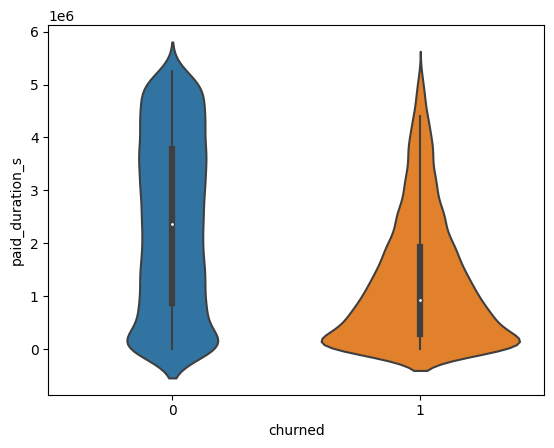

In [58]:
sns.violinplot(data=feature_pdf, x="churned", y="paid_duration_s")

<Axes: xlabel='churned', ylabel='paid_duration_days'>

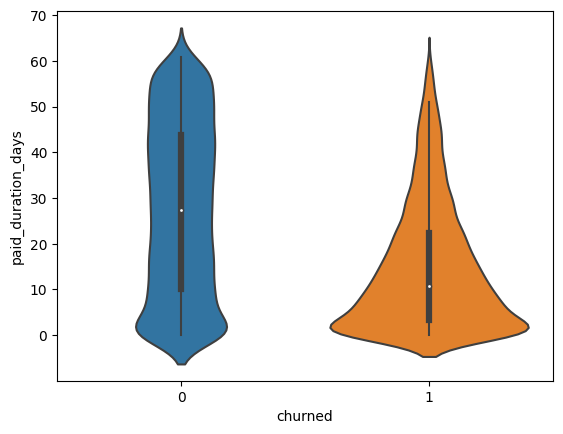

In [59]:
feature_pdf["paid_duration_days"] = feature_pdf.paid_duration_s/(86400)
sns.violinplot(data=feature_pdf, x="churned", y="paid_duration_days")

In [60]:
feature_pdf["paid_duration_days"].mean()

21.15395596881156

In [61]:
raw_df.where(f.col("userId")==1814132).sort("ts",ascending=False).show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|          page| registration|sessionId|                song|status|           ts|           userAgent| userId|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------------+-------------+---------+--------------------+------+-------------+--------------------+-------+
|                null|Logged In|  Jackson|     M|           19|Fernandez|     null| paid|Vineland-Bridgeto...|   GET|          Home|1536685104000|   169530|                null|   200|1542823326000|"Mozilla/5.0 (Mac...|1814132|
|                null|Logged In|  Jackson|     M|           18|Fernandez|     null| free

## Unique Artists

In [62]:
df_unique_artists = df.groupby("userId_paid_phase").agg(f.countDistinct("artist").alias("unique_artist_count"))
feature_df = feature_df.join(df_unique_artists, on="userId_paid_phase", how="left")
feature_df.sort("unique_artist_count").show(5)
feature_df.sort(f.desc("unique_artist_count")).show(5)

+-----------------+-------+-------+---------------+-------------------+
|userId_paid_phase|churned| userId|paid_duration_s|unique_artist_count|
+-----------------+-------+-------+---------------+-------------------+
|        1454299_1|      0|1454299|            5.0|                  0|
|        1705731_1|      0|1705731|            9.0|                  0|
|        1299760_1|      1|1299760|            6.0|                  0|
|        1849103_1|      0|1849103|           79.0|                  0|
|        1374883_1|      0|1374883|            8.0|                  0|
+-----------------+-------+-------+---------------+-------------------+
only showing top 5 rows

+-----------------+-------+-------+---------------+-------------------+
|userId_paid_phase|churned| userId|paid_duration_s|unique_artist_count|
+-----------------+-------+-------+---------------+-------------------+
|        1478099_1|      0|1478099|      4507984.0|               3607|
|        1604861_2|      1|1604861|    

In [63]:
# Plot some results
feature_pdf = feature_df.toPandas()

In [64]:
feature_pdf

,userId_paid_phase,churned,userId,paid_duration_s,unique_artist_count
0,1000409_1,0,1000409,5052724.0,1551
1,1005928_1,1,1005928,1942924.0,731
2,1006980_2,0,1006980,303325.0,216
3,1007696_1,1,1007696,449553.0,260
4,1012419_1,1,1012419,792251.0,418
...,...,...,...,...,...
15130,1963453_1,0,1963453,520360.0,91
15131,1968370_1,0,1968370,3121292.0,753
15132,1970702_1,0,1970702,6109.0,24
15133,1972195_1,0,1972195,3586903.0,1622


In [65]:
feature_pdf.groupby("churned").describe()

paid_duration_s                                              \
                  count          mean           std  min        25%   
churned                                                               
0                7617.0  2.372194e+06  1.624476e+06  0.0  867052.00   
1                7518.0  1.276039e+06  1.199272e+06  6.0  287765.25   

                                          unique_artist_count              \
               50%         75%        max               count        mean   
churned                                                                     
0        2369973.0  3780124.00  5261687.0              7617.0  632.680320   
1         931748.5  1936565.25  5227519.0              7518.0  562.966081   

                                                       
                std  min    25%    50%    75%     max  
churned                                                
0        524.975102  0.0  232.0  502.0  912.0  3607.0  
1        510.265697  0.0  172.0  414.0  811.0  3579.0

In [66]:
feature_pdf["dummy"]=""

<Axes: xlabel='dummy', ylabel='unique_artist_count'>

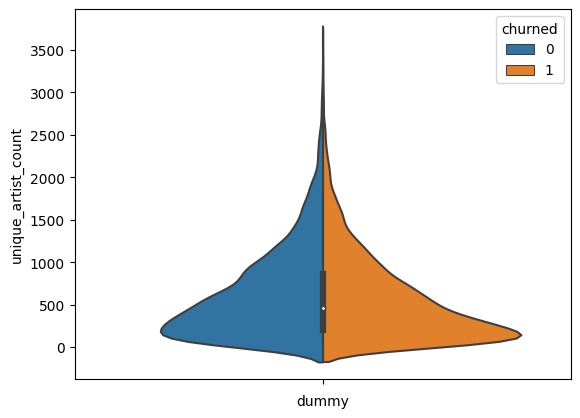

In [67]:
sns.violinplot(data=feature_pdf,y="unique_artist_count", x="dummy", hue="churned", split=True)

## Gender

In [68]:
df_gender = df.withColumn("gender_encoded_male_1",f.when(f.col("gender")=="M",1).otherwise(0)).groupby("userId_paid_phase").agg(f.max("gender_encoded_male_1").alias("male_1_female_0"))
feature_df = feature_df.join(df_gender, on="userId_paid_phase", how="left")
feature_df.show(5)

+-----------------+-------+-------+---------------+-------------------+---------------+
|userId_paid_phase|churned| userId|paid_duration_s|unique_artist_count|male_1_female_0|
+-----------------+-------+-------+---------------+-------------------+---------------+
|        1000409_1|      0|1000409|      5052724.0|               1551|              1|
|        1005928_1|      1|1005928|      1942924.0|                731|              0|
|        1006980_2|      0|1006980|       303325.0|                216|              1|
|        1007696_1|      1|1007696|       449553.0|                260|              1|
|        1012419_1|      1|1012419|       792251.0|                418|              1|
+-----------------+-------+-------+---------------+-------------------+---------------+
only showing top 5 rows



In [69]:
feature_pdf = feature_df.toPandas()
feature_pdf

,userId_paid_phase,churned,userId,paid_duration_s,unique_artist_count,male_1_female_0
0,1000409_1,0,1000409,5052724.0,1551,1
1,1005928_1,1,1005928,1942924.0,731,0
2,1006980_2,0,1006980,303325.0,216,1
3,1007696_1,1,1007696,449553.0,260,1
4,1012419_1,1,1012419,792251.0,418,1
...,...,...,...,...,...,...
15130,1963453_1,0,1963453,520360.0,91,1
15131,1968370_1,0,1968370,3121292.0,753,0
15132,1970702_1,0,1970702,6109.0,24,1
15133,1972195_1,0,1972195,3586903.0,1622,0


In [70]:
# Look at the percentage of each gender that churn?
gender_summary_pdf = feature_pdf.groupby("male_1_female_0").apply(lambda x: pd.Series({"total_count":x["churned"].count(), "churned_count":x["churned"].sum()}))
gender_summary_pdf

,total_count,churned_count
male_1_female_0,,
0,7246,3611
1,7889,3907


In [71]:
gender_summary_pdf["pct_churn"] = gender_summary_pdf.churned_count / gender_summary_pdf.total_count * 100
gender_summary_pdf

,total_count,churned_count,pct_churn
male_1_female_0,,,
0,7246,3611,49.834391
1,7889,3907,49.524655


In [72]:
(3611+3907)/(7246+7889)*100

49.67294350842418

The percentage of users that have churned is 49.7%, and that varies very minimally for different genders. It is tempting to omit gender as a feature, but it could be that when combined with other features it is useful in making predictions.

## itemIn Session Column

In [73]:
# Understand how this column works:
df.sort("userId_paid_phase").select("userId", "userId_paid_phase", "ts", "itemInSession", "page").show()

+-------+-----------------+-------------+-------------+--------------+
| userId|userId_paid_phase|           ts|itemInSession|          page|
+-------+-----------------+-------------+-------------+--------------+
|1000025|        1000025_1|1538510602000|           31|Submit Upgrade|
|1000025|        1000025_1|1538510666000|           32|          Home|
|1000025|        1000025_1|1538511056000|           33|      NextSong|
|1000025|        1000025_1|1538511302000|           34|      NextSong|
|1000025|        1000025_1|1538511796000|           35|      NextSong|
|1000025|        1000025_1|1538512067000|           36|      NextSong|
|1000025|        1000025_1|1538512276000|           37|      NextSong|
|1000025|        1000025_1|1538512560000|           38|      NextSong|
|1000025|        1000025_1|1538512898000|           39|      NextSong|
|1000025|        1000025_1|1538513160000|           40|      NextSong|
|1000025|        1000025_1|1538513161000|           41|     Thumbs Up|
|10000

In [74]:
# Can see each row increments the itemInSession count by 1, wheras I am interested in the total
# number of items in each session, i.e. the "peaks" of the values before they drop down again.
w = Window.partitionBy("userId_paid_phase").orderBy("ts")
last_row_window = Window.partitionBy("userId_paid_phase",).orderBy(f.desc('ts'))

df_max_items_in_sessions = (
    df
    .sort("userId_paid_phase")
    .select("userId", "userId_paid_phase", "ts", "itemInSession", "page")
    .withColumn("prev_item",f.lag("itemInSession").over(w))
    .withColumn("item_minus_prev",f.col("itemInSession")-f.col("prev_item"))
    .withColumn("row_num", f.row_number().over(last_row_window))
    .where((f.col("item_minus_prev")<1) | (f.col("row_num")==1))
    .select("userId_paid_phase",f.col("prev_item").alias("items_in_session_counts"))
)
df_max_items_in_sessions.show(5)

#.where(f.col("item_minus_prev")<1).select("",f.col("prev_item").alias("session_peaks")).show()

# Note, the count for the last row is off by 1 (as we take the previous row value) but should
# be good enough as these numbers are comparitvely large and have spent excessive time already.

+-----------------+-----------------------+
|userId_paid_phase|items_in_session_counts|
+-----------------+-----------------------+
|        1000025_1|                    118|
|        1000025_1|                    277|
|        1000025_1|                      7|
|        1000025_1|                    156|
|        1000025_1|                     98|
+-----------------+-----------------------+
only showing top 5 rows



In [75]:
#also need to keep last row per paid period?
df_max_items_in_sessions.where(f.col("userId_paid_phase")=="1999908_1").show()

+-----------------+-----------------------+
|userId_paid_phase|items_in_session_counts|
+-----------------+-----------------------+
|        1999908_1|                     36|
+-----------------+-----------------------+



In [76]:
df.where(f.col("userId_paid_phase")=="1999908_1").show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------------+-------------+---------+--------------------+------+-------------+--------------------+-------+------------+-----------+------------+-------------+-----------------+----------+--------------+-------------+---------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|          page| registration|sessionId|                song|status|           ts|           userAgent| userId|level_change|level_phase|upgrade_flag|upgrade_phase|userId_paid_phase|downgraded|level_start_ts|      last_ts|paid_duration_s|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------------+-------------+---------+--------------------+------+-------------+--------------------+-------+------------+-----------+------------+-------------+----------------

In [77]:
# Possible improvement option to investigate in the future - if should "reset" the item count at the start of a paid session, or keep both.

In [78]:
df_itemInSession = df_max_items_in_sessions.groupby("userId_paid_phase").agg(f.mean("items_in_session_counts").alias("mean(items_in_session_counts)"))

In [79]:
feature_df = feature_df.join(df_itemInSession, on="userId_paid_phase", how="left")
feature_df.show(2)

+-----------------+-------+-------+---------------+-------------------+---------------+-----------------------------+
|userId_paid_phase|churned| userId|paid_duration_s|unique_artist_count|male_1_female_0|mean(items_in_session_counts)|
+-----------------+-------+-------+---------------+-------------------+---------------+-----------------------------+
|        1000409_1|      0|1000409|      5052724.0|               1551|              1|           106.28571428571429|
|        1005928_1|      1|1005928|      1942924.0|                731|              0|            97.91666666666667|
+-----------------+-------+-------+---------------+-------------------+---------------+-----------------------------+
only showing top 2 rows



In [80]:
feature_pdf = feature_df.toPandas()
feature_pdf

,userId_paid_phase,churned,userId,paid_duration_s,unique_artist_count,male_1_female_0,mean(items_in_session_counts)
0,1000409_1,0,1000409,5052724.0,1551,1,106.285714
1,1005928_1,1,1005928,1942924.0,731,0,97.916667
2,1006980_2,0,1006980,303325.0,216,1,102.000000
3,1007696_1,1,1007696,449553.0,260,1,93.500000
4,1012419_1,1,1012419,792251.0,418,1,100.833333
...,...,...,...,...,...,...,...
15130,1963453_1,0,1963453,520360.0,91,1,55.000000
15131,1968370_1,0,1968370,3121292.0,753,0,148.000000
15132,1970702_1,0,1970702,6109.0,24,1,69.000000
15133,1972195_1,0,1972195,3586903.0,1622,0,130.800000


<Axes: xlabel='churned', ylabel='mean(items_in_session_counts)'>

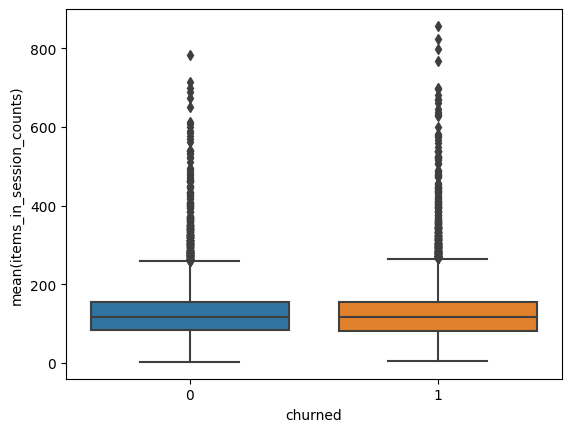

In [81]:
sns.boxplot(data=feature_pdf,y="mean(items_in_session_counts)",x='churned')

In [82]:
feature_df.columns

['userId_paid_phase',
 'churned',
 'userId',
 'paid_duration_s',
 'unique_artist_count',
 'male_1_female_0',
 'mean(items_in_session_counts)']

# Review various columns looking at total count, and average past week compared to overall average

In [83]:
# df_songs_played = (
#     df
#     .where(f.col("page")=="NextSong")
#     .groupby("userId_paid_phase").agg(f.count("artist").alias("total_song_count"))
# )
# df_songs_played.show()

In [84]:

# Future improvement - It sounds reasonable that some of the churned users could be using the service less than they used to,
# so would like to try and generate a feature that compares the number of songs played recently, to the 
# number of songs played in the past. Ideally need to know when "now" is to calculate features like:
# "average songs per day last week vs average songs per day since upgrading"

# As we are not sure when "now" is, just look at the previous 1 week before either churning or the last interaction

In [85]:
one_week_in_ms = 1000 * 60 * 60 * 24 * 7
df = df.withColumn("one_week_prior_ts", f.col("last_ts") - one_week_in_ms)

In [86]:
feature_df.columns

['userId_paid_phase',
 'churned',
 'userId',
 'paid_duration_s',
 'unique_artist_count',
 'male_1_female_0',
 'mean(items_in_session_counts)']

In [93]:
df.columns

['artist',
 'auth',
 'firstName',
 'gender',
 'itemInSession',
 'lastName',
 'length',
 'level',
 'location',
 'method',
 'page',
 'registration',
 'sessionId',
 'song',
 'status',
 'ts',
 'userAgent',
 'userId',
 'level_change',
 'level_phase',
 'upgrade_flag',
 'upgrade_phase',
 'userId_paid_phase',
 'downgraded',
 'level_start_ts',
 'last_ts',
 'paid_duration_s',
 'one_week_prior_ts']

In [87]:
# feature_df = feature_df.drop('page_NextSong_total_count',
#  'page_NextSong_last_week_count')

In [88]:
col_values_to_count = [
    {"c":"page", "v":"NextSong"},
    {"c":"page", "v":"Thumbs Up"},
    {"c":"page", "v":"Thumbs Down"},
    {"c":"page", "v":"Downgrade"},
    {"c":"page", "v":"Cancel"},
    {"c":"page", "v":"Help"},
    {"c":"status", "v":404},
]

In [94]:

def process_value_to_count(input_df, col, value,feature_df):
    """calculate a new feature using the col and value field 
    on the input_df, and return the feature_df with a new column
    Also plot the results for review"""
    
    new_feature_total_col_name = f"{col}_{value}_total_count"
    new_feature_last_week_count_col_name = f"{col}_{value}_last_week_count"
    new_feature_last_week_pct_col_name = f"{col}_{value}_last_week_to_total_rate_ratio_pct"
    
    new_feature_df = (
        input_df
        .where(f.col(col)==value).groupby("userId_paid_phase")
        .agg(
            f.count(col).alias(new_feature_total_col_name),
            f.max("paid_duration_s").alias("paid_duration_s")
        )   
    )
    
    last_week_df = (
        input_df.where(f.col("ts")>=f.col("one_week_prior_ts"))
        .where(f.col(col)==value).groupby("userId_paid_phase")
        .agg(f.count(col).alias(new_feature_last_week_count_col_name))
    )
    new_feature_df = new_feature_df.join(last_week_df, on="userId_paid_phase", how="left")
    new_feature_df = (
        new_feature_df
        .withColumn(new_feature_last_week_pct_col_name,
                    ((f.col(new_feature_last_week_count_col_name))/(604800))
                    /
                    ((f.col(new_feature_total_col_name))/(f.col("paid_duration_s")))
                    *100
        )
    )
    
    feature_df = feature_df.join(new_feature_df.drop("paid_duration_s"), on="userId_paid_phase", how="left")
    feature_df = feature_df.fillna(0, subset=new_feature_total_col_name)
    
    return feature_df

In [95]:
feature_df.columns

['userId_paid_phase',
 'churned',
 'userId',
 'paid_duration_s',
 'unique_artist_count',
 'male_1_female_0',
 'mean(items_in_session_counts)']

In [96]:
for c_v_dict in col_values_to_count:
    col = c_v_dict["c"]
    value = c_v_dict["v"]
    print(f"\nProcessing count of value {value} in column {col} ...")
    feature_df = process_value_to_count(input_df=df,col=col,value=value, feature_df=feature_df)


Processing count of value NextSong in column page ...

Processing count of value Thumbs Up in column page ...

Processing count of value Thumbs Down in column page ...

Processing count of value Downgrade in column page ...

Processing count of value Cancel in column page ...

Processing count of value Help in column page ...

Processing count of value 404 in column status ...


In [97]:
feat_pdf = feature_df.toPandas()
feat_pdf

,userId_paid_phase,churned,userId,paid_duration_s,unique_artist_count,male_1_female_0,mean(items_in_session_counts),page_NextSong_total_count,paid_duration_s,page_NextSong_last_week_count,...,page_Cancel_last_week_count,page_Cancel_last_week_to_total_rate_ratio_pct,page_Help_total_count,paid_duration_s,page_Help_last_week_count,page_Help_last_week_to_total_rate_ratio_pct,status_404_total_count,paid_duration_s,status_404_last_week_count,status_404_last_week_to_total_rate_ratio_pct
0,1000409_1,0,1000409,5052724.0,1551,1,106.285714,2462,5052724.0,68.0,...,NaN,NaN,14,5052724.0,NaN,NaN,2,5052724.0,NaN,NaN
1,1005928_1,1,1005928,1942924.0,731,0,97.916667,931,1942924.0,336.0,...,1.0,321.250661,6,1942924.0,2.0,107.083554,2,1942924.0,NaN,NaN
2,1006980_2,0,1006980,303325.0,216,1,102.000000,233,303325.0,233.0,...,NaN,NaN,3,303325.0,3.0,50.152943,0,NaN,NaN,NaN
3,1007696_1,1,1007696,449553.0,260,1,93.500000,302,449553.0,302.0,...,1.0,74.330853,3,449553.0,3.0,74.330853,0,NaN,NaN,NaN
4,1012419_1,1,1012419,792251.0,418,1,100.833333,492,792251.0,260.0,...,1.0,130.993882,6,792251.0,1.0,21.832314,2,792251.0,2.0,130.993882
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15130,1929643_1,0,1929643,2996061.0,57,0,57.000000,57,2996061.0,9.0,...,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
15131,1939562_1,0,1939562,2814130.0,309,0,50.222222,347,2814130.0,37.0,...,NaN,NaN,1,2814130.0,NaN,NaN,1,2814130.0,NaN,NaN
15132,1963453_1,0,1963453,520360.0,91,1,55.000000,94,520360.0,94.0,...,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN
15133,1968370_1,0,1968370,3121292.0,753,0,148.000000,972,3121292.0,131.0,...,NaN,NaN,8,3121292.0,3.0,193.532490,1,3121292.0,NaN,NaN


In [98]:
feat_pdf.describe()

,churned,paid_duration_s,unique_artist_count,male_1_female_0,mean(items_in_session_counts),page_NextSong_total_count,paid_duration_s,page_NextSong_last_week_count,page_NextSong_last_week_to_total_rate_ratio_pct,page_Thumbs Up_total_count,...,page_Cancel_last_week_count,page_Cancel_last_week_to_total_rate_ratio_pct,page_Help_total_count,paid_duration_s,page_Help_last_week_count,page_Help_last_week_to_total_rate_ratio_pct,status_404_total_count,paid_duration_s,status_404_last_week_count,status_404_last_week_to_total_rate_ratio_pct
count,15135.000000,1.513500e+04,15135.000000,15135.000000,15134.000000,15135.000000,1.509100e+04,15048.000000,15048.000000,15135.000000,...,2478.0,2478.000000,15135.000000,1.242000e+04,9901.000000,9901.000000,15135.000000,7.276000e+03,3889.000000,3889.000000
mean,0.496729,1.827702e+06,598.051206,0.521242,127.512557,835.909481,1.833030e+06,293.794790,94.138829,46.468847,...,1.0,212.200466,5.041956,2.098481e+06,2.692354,129.415415,0.972580,2.429295e+06,1.330933,198.556978
std,0.500006,1.530613e+06,518.875819,0.499565,69.731769,888.406615,1.529653e+06,265.144123,77.784731,54.262517,...,0.0,199.038958,5.779518,1.499166e+06,2.005470,108.336635,1.419987,1.487435e+06,0.640916,162.349994
min,0.000000,0.000000e+00,0.000000,0.000000,3.000000,0.000000,1.090000e+02,1.000000,0.018022,0.000000,...,1.0,0.006779,0.000000,6.150000e+02,1.000000,0.101687,0.000000,2.940000e+02,1.000000,0.048611
25%,0.000000,4.758910e+05,199.000000,0.000000,83.600000,217.000000,4.824695e+05,95.000000,38.479955,11.000000,...,1.0,47.489335,1.000000,7.889685e+05,1.000000,60.979497,0.000000,1.144102e+06,1.000000,87.078869
50%,0.000000,1.465189e+06,460.000000,1.000000,116.666667,548.000000,1.473595e+06,216.000000,83.217338,29.000000,...,1.0,155.281333,3.000000,1.838656e+06,2.000000,101.629092,0.000000,2.298418e+06,1.000000,152.372024
75%,1.000000,3.023980e+06,865.000000,1.000000,155.000000,1160.000000,3.031664e+06,419.000000,127.096273,63.000000,...,1.0,326.469370,7.000000,3.304188e+06,4.000000,165.495260,1.000000,3.685304e+06,2.000000,264.095073
max,1.000000,5.261687e+06,3607.000000,1.000000,857.000000,8337.000000,5.261687e+06,1833.000000,715.635346,663.000000,...,1.0,864.338459,66.000000,5.261687e+06,16.000000,843.998347,14.000000,5.261687e+06,5.000000,861.008433


<Axes: xlabel='churned', ylabel='page_NextSong_last_week_to_total_rate_ratio_pct'>

<Figure size 640x480 with 0 Axes>

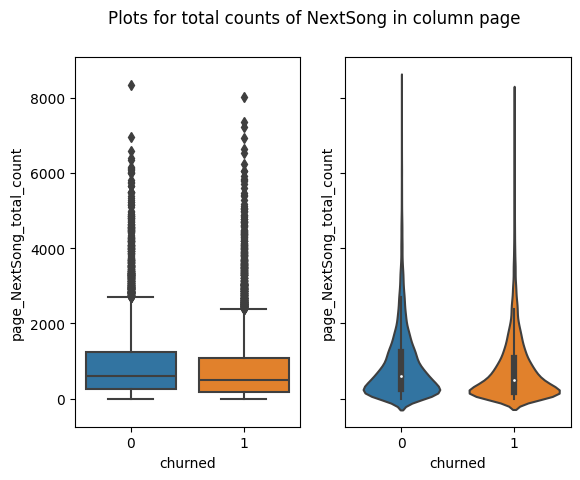

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

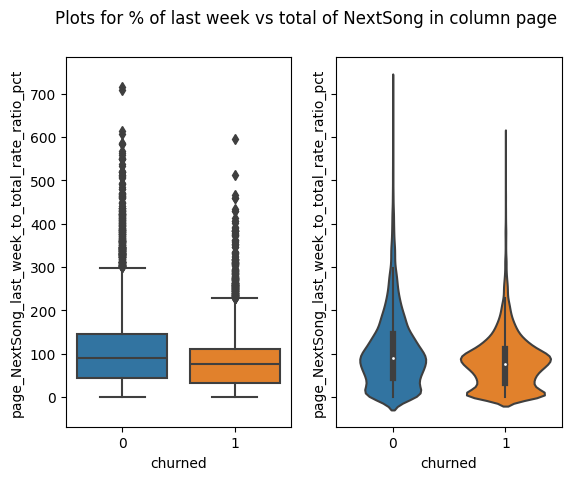

<Figure size 640x480 with 0 Axes>

In [101]:
col = "page"
value = "NextSong"
new_feature_total_col_name = f"{col}_{value}_total_count"
new_feature_last_week_pct_col_name = f"{col}_{value}_last_week_to_total_rate_ratio_pct"

plt.figure()
fig, (bp,vp) = plt.subplots(1,2, sharey=True)

fig.suptitle(f"Plots for total counts of {value} in column {col}")
sns.boxplot(ax=bp, data=feat_pdf, y=new_feature_total_col_name, x="churned")

plt.figure()
sns.violinplot(ax=vp, data=feat_pdf, y=new_feature_total_col_name, x="churned")


plt.figure()
fig, (bp,vp) = plt.subplots(1,2, sharey=True)

fig.suptitle(f"Plots for % of last week vs total of {value} in column {col}")
sns.boxplot(ax=bp, data=feat_pdf, y=new_feature_last_week_pct_col_name, x="churned")

plt.figure()
sns.violinplot(ax=vp, data=feat_pdf, y=new_feature_last_week_pct_col_name, x="churned")



Displaying visuals for value NextSong in column page ...

Displaying visuals for value Thumbs Up in column page ...

Displaying visuals for value Thumbs Down in column page ...

Displaying visuals for value Downgrade in column page ...


C:\Users\Matthew.Hull\AppData\Local\Temp\ipykernel_35960\1692939130.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()



Displaying visuals for value Cancel in column page ...

Displaying visuals for value Help in column page ...

Displaying visuals for value 404 in column status ...


<Figure size 640x480 with 0 Axes>

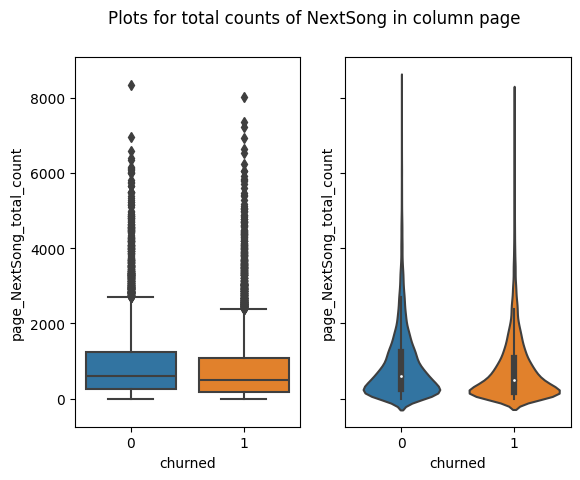

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

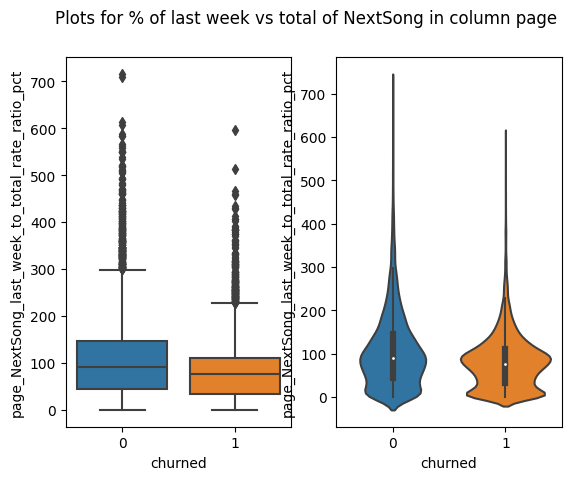

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

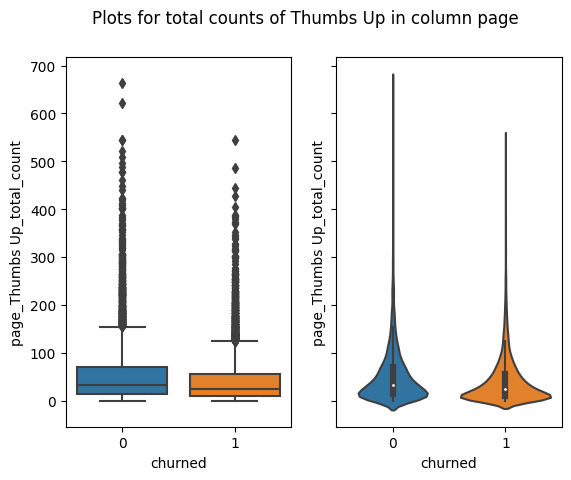

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

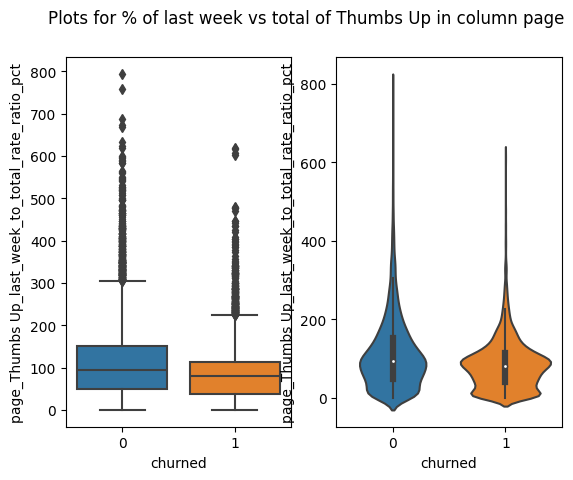

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

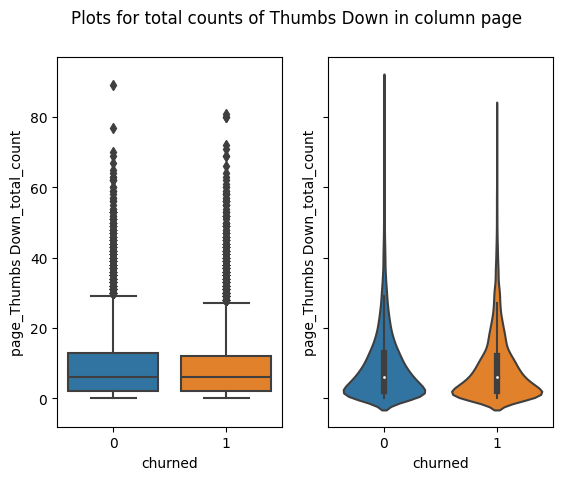

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

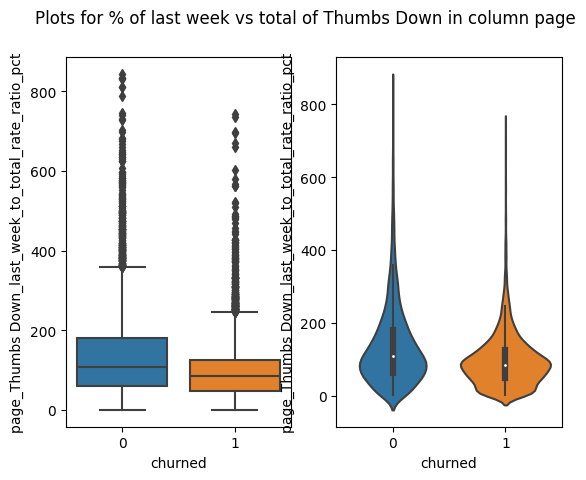

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

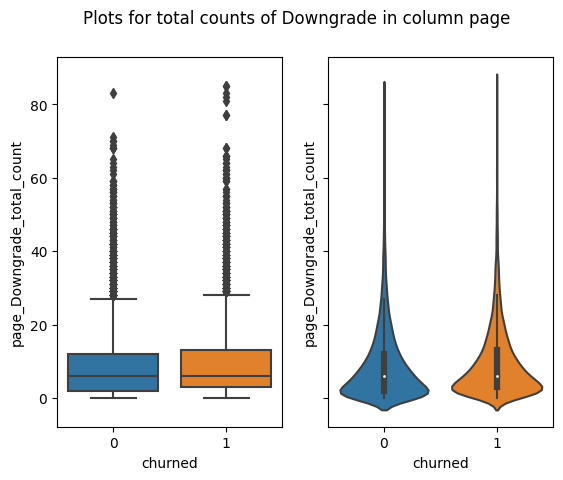

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

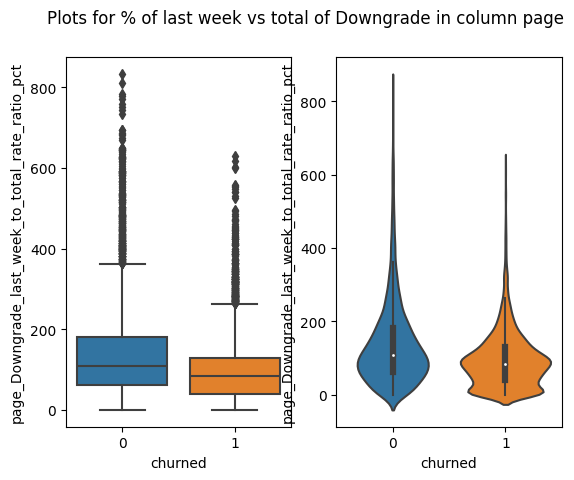

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

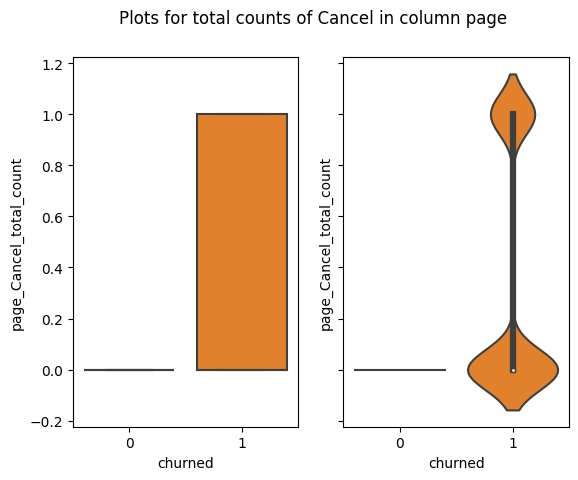

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

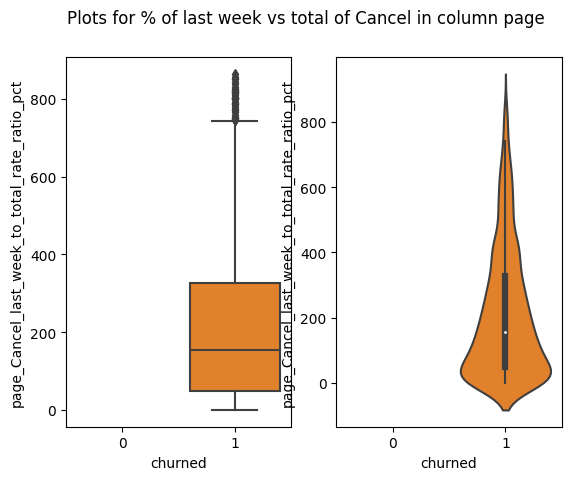

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

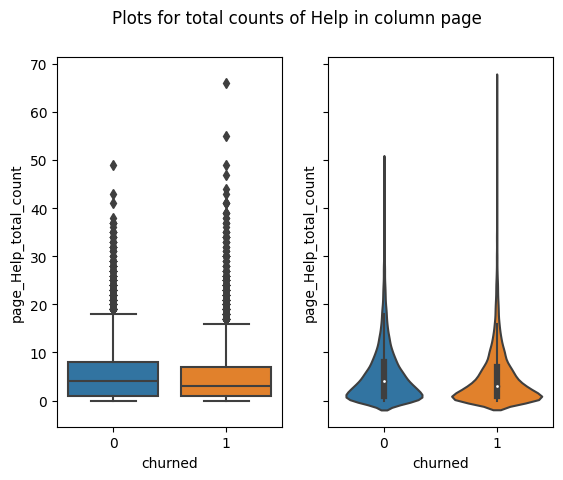

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

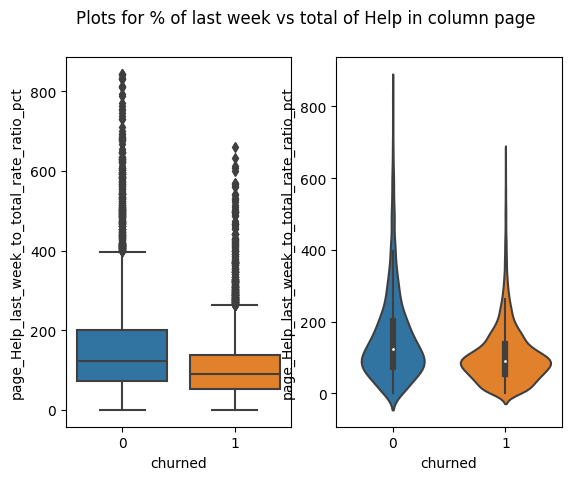

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

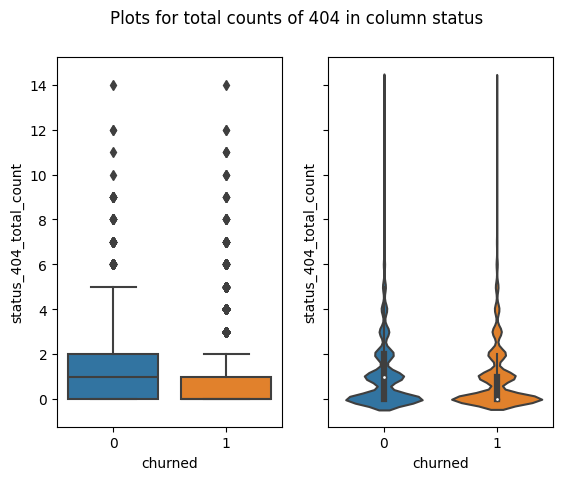

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

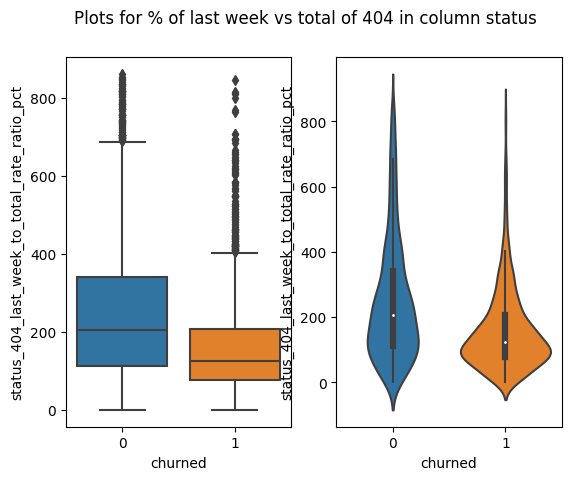

<Figure size 640x480 with 0 Axes>

In [102]:
# Plot New Features
def display_plots(pdf, list_of_col_val_dict):
    f_pdf = pdf
    
    for c_v_dict in list_of_col_val_dict:
        col = c_v_dict["c"]
        value = c_v_dict["v"]
        print(f"\nDisplaying visuals for value {value} in column {col} ...")
        new_feature_total_col_name = f"{col}_{value}_total_count"
        new_feature_last_week_pct_col_name = f"{col}_{value}_last_week_to_total_rate_ratio_pct"
    
        plt.figure()
        fig, (bp,vp) = plt.subplots(1,2, sharey=True)
        
        fig.suptitle(f"Plots for total counts of {value} in column {col}")
        sns.boxplot(ax=bp, data=f_pdf, y=new_feature_total_col_name, x="churned")
        
        plt.figure()
        sns.violinplot(ax=vp, data=f_pdf, y=new_feature_total_col_name, x="churned")
        
        
        plt.figure()
        fig, (bp,vp) = plt.subplots(1,2)
        
        fig.suptitle(f"Plots for % of last week vs total of {value} in column {col}")
        sns.boxplot(ax=bp, data=f_pdf, y=new_feature_last_week_pct_col_name, x="churned")
        
        plt.figure()
        sns.violinplot(ax=vp, data=f_pdf, y=new_feature_last_week_pct_col_name, x="churned")




display_plots(feat_pdf, col_values_to_count)

In [103]:
feature_df.columns

['userId_paid_phase',
 'churned',
 'userId',
 'paid_duration_s',
 'unique_artist_count',
 'male_1_female_0',
 'mean(items_in_session_counts)',
 'page_NextSong_total_count',
 'paid_duration_s',
 'page_NextSong_last_week_count',
 'page_NextSong_last_week_to_total_rate_ratio_pct',
 'page_Thumbs Up_total_count',
 'paid_duration_s',
 'page_Thumbs Up_last_week_count',
 'page_Thumbs Up_last_week_to_total_rate_ratio_pct',
 'page_Thumbs Down_total_count',
 'paid_duration_s',
 'page_Thumbs Down_last_week_count',
 'page_Thumbs Down_last_week_to_total_rate_ratio_pct',
 'page_Downgrade_total_count',
 'paid_duration_s',
 'page_Downgrade_last_week_count',
 'page_Downgrade_last_week_to_total_rate_ratio_pct',
 'page_Cancel_total_count',
 'paid_duration_s',
 'page_Cancel_last_week_count',
 'page_Cancel_last_week_to_total_rate_ratio_pct',
 'page_Help_total_count',
 'paid_duration_s',
 'page_Help_last_week_count',
 'page_Help_last_week_to_total_rate_ratio_pct',
 'status_404_total_count',
 'paid_duration_s

## Comments:

- visits to the cancel page - all users that don't churn have never gone to the cancel page. Whilst some of the users that churn don't visit the page, that could also be because they only downgrade and don't cancel their accounts. We are not sure what happens on this interaction, it seems like you only reach that page if you have churned already, so will be removed from the data.
(Otherwise the model will use the fact that never got to the cancel page to predict no churn, but in reality that is too late)

In [104]:
feature_df = feature_df.drop('page_Cancel_last_week_count',
 'page_Cancel_last_week_pct',)

Possible feature improvements - look at percentages of each item against other values as well as the total counts. Again also compare "recent" counts/percentages to overall counts/percentages to try and detect a change in behaviour

# Making a Model to predict Churn

As we are trying to determine if a "user paying period" falls into a category of churned / not churned, we have a __classification__ problem to solve.

Supported classification algorithms in spark.ml include:
- Logistic Regression
- Random Forests - _chosen to try on our data_
- Gradient-Boosted Trees
- Support Vector Machines - _chosen to try on our data_
- Naive Bayes

In [109]:
# Check no missing values
feature_df.select([f.count(f.when(f.col(c).isNull(), c)).alias(c) for c in feature_df.columns]).show()

+-----------------+-------+------+---------------+-------------------+---------------+-----------------------------+-------------------------+-----------------------------+-----------------------------------------------+--------------------------+------------------------------+------------------------------------------------+----------------------------+--------------------------------+--------------------------------------------------+--------------------------+------------------------------+------------------------------------------------+-----------------------+---------------------------------------------+---------------------+-------------------------+-------------------------------------------+----------------------+--------------------------+--------------------------------------------+
|userId_paid_phase|churned|userId|paid_duration_s|unique_artist_count|male_1_female_0|mean(items_in_session_counts)|page_NextSong_total_count|page_NextSong_last_week_count|page_NextSong_last_week

In [110]:
# need to fill missing values with 0, which is where the user didn't have any of those events, e.g. never went to Help page etc.
feature_df = feature_df.fillna(0)

In [111]:
feature_df = feature_df.persist()

In [112]:
print(f"features_df has {feature_df.count()} rows and {len(feature_df.columns)} cols")

features_df has 15135 rows and 27 cols


In [113]:
feature_df.printSchema()

root
 |-- userId_paid_phase: string (nullable = false)
 |-- churned: integer (nullable = true)
 |-- userId: string (nullable = true)
 |-- paid_duration_s: double (nullable = false)
 |-- unique_artist_count: long (nullable = true)
 |-- male_1_female_0: integer (nullable = true)
 |-- mean(items_in_session_counts): double (nullable = false)
 |-- page_NextSong_total_count: long (nullable = true)
 |-- page_NextSong_last_week_count: long (nullable = true)
 |-- page_NextSong_last_week_to_total_rate_ratio_pct: double (nullable = false)
 |-- page_Thumbs Up_total_count: long (nullable = true)
 |-- page_Thumbs Up_last_week_count: long (nullable = true)
 |-- page_Thumbs Up_last_week_to_total_rate_ratio_pct: double (nullable = false)
 |-- page_Thumbs Down_total_count: long (nullable = true)
 |-- page_Thumbs Down_last_week_count: long (nullable = true)
 |-- page_Thumbs Down_last_week_to_total_rate_ratio_pct: double (nullable = false)
 |-- page_Downgrade_total_count: long (nullable = true)
 |-- page_

## Transform Features

In [114]:
feature_df.columns

['userId_paid_phase',
 'churned',
 'userId',
 'paid_duration_s',
 'unique_artist_count',
 'male_1_female_0',
 'mean(items_in_session_counts)',
 'page_NextSong_total_count',
 'page_NextSong_last_week_count',
 'page_NextSong_last_week_to_total_rate_ratio_pct',
 'page_Thumbs Up_total_count',
 'page_Thumbs Up_last_week_count',
 'page_Thumbs Up_last_week_to_total_rate_ratio_pct',
 'page_Thumbs Down_total_count',
 'page_Thumbs Down_last_week_count',
 'page_Thumbs Down_last_week_to_total_rate_ratio_pct',
 'page_Downgrade_total_count',
 'page_Downgrade_last_week_count',
 'page_Downgrade_last_week_to_total_rate_ratio_pct',
 'page_Cancel_total_count',
 'page_Cancel_last_week_to_total_rate_ratio_pct',
 'page_Help_total_count',
 'page_Help_last_week_count',
 'page_Help_last_week_to_total_rate_ratio_pct',
 'status_404_total_count',
 'status_404_last_week_count',
 'status_404_last_week_to_total_rate_ratio_pct']

In [115]:
input_cols = feature_df.columns[3:]
target_col = "churned"

In [117]:
feature_df.schema["userId"].dataType

StringType()

In [118]:
numerical_cols = [c for c in input_cols if c!="male_1_female_0"]

In [119]:
# convert numerical cols to vectors:

assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features_vector")
feature_df = assembler.transform(feature_df)

In [120]:
feature_df.columns

['userId_paid_phase',
 'churned',
 'userId',
 'paid_duration_s',
 'unique_artist_count',
 'male_1_female_0',
 'mean(items_in_session_counts)',
 'page_NextSong_total_count',
 'page_NextSong_last_week_count',
 'page_NextSong_last_week_to_total_rate_ratio_pct',
 'page_Thumbs Up_total_count',
 'page_Thumbs Up_last_week_count',
 'page_Thumbs Up_last_week_to_total_rate_ratio_pct',
 'page_Thumbs Down_total_count',
 'page_Thumbs Down_last_week_count',
 'page_Thumbs Down_last_week_to_total_rate_ratio_pct',
 'page_Downgrade_total_count',
 'page_Downgrade_last_week_count',
 'page_Downgrade_last_week_to_total_rate_ratio_pct',
 'page_Cancel_total_count',
 'page_Cancel_last_week_to_total_rate_ratio_pct',
 'page_Help_total_count',
 'page_Help_last_week_count',
 'page_Help_last_week_to_total_rate_ratio_pct',
 'status_404_total_count',
 'status_404_last_week_count',
 'status_404_last_week_to_total_rate_ratio_pct',
 'numerical_features_vector']

In [121]:
scaler = StandardScaler(inputCol="numerical_features_vector", outputCol="scaled_numerical_features_vector", withMean=True, withStd=True)
scalerModel = scaler.fit(feature_df)
feature_df = scalerModel.transform(feature_df)

In [122]:
# Add back the gender input col:
assembler = VectorAssembler(inputCols=["scaled_numerical_features_vector","male_1_female_0"], outputCol="features_vec")
feature_df = assembler.transform(feature_df)

In [123]:
model_df = feature_df.select(f.col("features_vec").alias("x"), f.col("churned").alias("Y"))
model_df.head()

Row(x=DenseVector([2.107, 1.8366, -0.3043, 1.8303, -0.8447, -0.9055, 1.2998, -0.9819, -1.0491, 1.6342, -0.6397, -0.581, 1.7284, -0.7335, -0.6414, -0.4425, -0.3089, 1.55, -0.8522, -0.7906, 0.7235, -0.5134, -0.4267, 1.0]), Y=0)

In [124]:
# temp cell to speed things up... re run one abovr when remove this
model_df,_ = model_df.randomSplit([0.1,0.9])

In [125]:
train, test = model_df.randomSplit([0.8, 0.2], seed=7)

## Baseline
We saw previously close to 50% of "user paid periods" churned, so if we were to randomly guess if that period churned with an equal probability (50%), we should achieve an accuracy of 50%.

## Random Forest

In [128]:
rf = RandomForestClassifier(labelCol="Y", 
                            featuresCol="x")

evaluator = BinaryClassificationEvaluator(rawPredictionCol="pred") # prediction

rf_param_grid = (
    ParamGridBuilder()
    .addGrid(rf.maxDepth, [5,10])
    .addGrid(rf.maxBins, [25,35])
    .build()
)

pipeline=Pipeline(stages=[rf])

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rf_param_grid,
    evaluator=BinaryClassificationEvaluator(labelCol="Y", ),
    numFolds=2
)

rf_model = crossval.fit(train)

In [132]:

model = rf_model
y_pred = model.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
evaluator.setLabelCol("Y")
auc = evaluator.evaluate(y_pred)

print(f"\t{auc=}")

print(f"Best model params: {model.bestModel.extractParamMap()}")

	auc=0.778395061728395
Best model params: {}


In [144]:
def evaluate_model(model, test):
    model
    y_pred = model.transform(test)

    evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction")
    evaluator.setLabelCol("Y")
    auc = evaluator.evaluate(y_pred)

    print(f"\t{auc=}")

    print(f"Best model params: {model.bestModel.extractParamMap()}")

## Support Vector Machine (SVM)

In [1]:
svc = LinearSVC(labelCol="Y", featuresCol="x")
pipeline = Pipeline(stages=[svc])
svc_param_grid = (ParamGridBuilder()
                 .addGrid(svc.aggregationDepth, [2,3])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=svc_param_grid,
    evaluator=evaluator,
    numFolds=2)

svc_model = crossval.fit(train)

NameError: name 'LinearSVC' is not defined

In [ ]:
evaluate_model(svc_model, test)

## Re-run models with input (if time allows)

In [ ]:
model_df = feature_df.select(f.col("features_vec").alias("x"), f.col("churned").alias("Y"))

train, test = model_df.randomSplit([0.8, 0.2], seed=77)

Row(x=DenseVector([2.107, 1.8366, -0.3043, 1.8303, -0.8447, -0.9055, 1.2998, -0.9819, -1.0491, 1.6342, -0.6397, -0.581, 1.7284, -0.7335, -0.6414, -0.4425, -0.3089, 1.55, -0.8522, -0.7906, 0.7235, -0.5134, -0.4267, 1.0]), Y=0)

## Random Forest

In [ ]:
rf = RandomForestClassifier(labelCol="Y", 
                            featuresCol="x")

evaluator = BinaryClassificationEvaluator(rawPredictionCol="prediction") # prediction

rf_param_grid = (
    ParamGridBuilder()
    .addGrid(rf.maxDepth, [5,10])
    .addGrid(rf.maxBins, [25,35])
    .build()
)

pipeline=Pipeline(stages=[rf])

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=rf_param_grid,
    evaluator=BinaryClassificationEvaluator(labelCol="Y", ),
    numFolds=2
)

rf_model = crossval.fit(train)

In [ ]:
evaluate_model(rf_model, test)

## Support Vector Machine (SVM)

In [ ]:
svc = LinearSVC(labelCol="Y", featuresCol="x")
pipeline = Pipeline(stages=[svc])
svc_param_grid = (ParamGridBuilder()
                 .addGrid(svc.aggregationDepth, [2,3])
                 .build())

crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=svc_param_grid,
    evaluator=evaluator,
    numFolds=2)

svc_model = crossval.fit(train)

In [ ]:
evaluate_model(svc_model, test)

# Improvements

- check / deal with users that might have upgraded multiple times
- Tune the period of "recent" activity to compare overall with, value different to 1 week could be better. Could also be a hyper parameter for the grid search in the pipeline. Adding the transform steps teo the pipeline also.
- Other feature ideas:
    - number of sessions (ever / over a period)
    - number of friends (ever / over a period) 
    - duration since registration
    - duration since upgrading to paid level
    -  day of the week / the week of the year?